In [1]:
import sqlite3
import csv
import re
# Getting data from csv file
lines_with_value = []
# is list of pair( list[ words in line/article] , list[its annotated value])
# function for text processing
def text_preprocessing(
    token:str,
    punctuations = r'''!()-[]{};:‘'’"\,<>./?@#$%^&*_“~''')->list:
    # print(token)
    token = re.sub(r"""[()\"#/@;:.<>{}`––‘+«’%-=~|!?"“”,']""", "", token)
    token = re.sub(r'[0-9]+','',token)
    token = re.sub("[A-Za-z]","",token)
    token = re.sub(" +"," ", token)
    return token

with open('/home/balu/cl2/project/datasets/telugu/smaller_dataset.csv', 'r') as total_file:
    data = csv.reader(total_file)
    next(data)
    for line in data:
        for k in reversed(line):
            if(k==''):
                del line[-1:]
            else:
                break
        i = len(line)
        k = (line[i-2],line[i-1])
        del line[-2:]
        temp = []
        for cell in line:
            cell = cell.split()
            for token in cell:
                processed_token = text_preprocessing(token)
                if(processed_token != ''):
                    temp.append(processed_token)
        lines_with_value.append((temp,k))
total_tokens = 0
for ele in lines_with_value:
    total_tokens += len(ele[0])
# List of pairs - pair = ([list of words],(party, Newspaper))

In [2]:
#Creating vectors for all words in the given training dataset
import itertools
import numpy as np
import re
import os
from tqdm import tqdm
from tensorflow import keras
import pandas as pd
import tensorflow as tf

# Drawing the embeddings
import matplotlib
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

# Deep learning: 
from keras.models import Model
from keras import Input
from keras.layers import Dense

from scipy import sparse

def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict 
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = [] #for a given sentence forming a word_list [ [word,word_before] , [word,word_after] ] 
# similarly doing this for every sentence
all_text = []# all_text = all words in the given corpus
texts = []
for text in lines_with_value:
    # Appending to the all text list
    text = text[0]
    for word in text:
        all_text.append(word)
    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):

            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])

            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

unique_word_dict = create_unique_word_dict(all_text)

fi = open('/home/balu/cl2/project/env/test_for_UH.txt','w')
for a in unique_word_dict.keys():
    print(a, file = fi)
fi.close()
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
XX = sparse.csr_matrix(X,dtype = (int,int))
YY = sparse.csr_matrix(Y)


Using TensorFlow backend.
51524it [00:02, 21545.72it/s]


In [3]:
#Defining Neural Network

#Defining the embed size
embed_size = 1

inp = Input(shape=(XX.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=YY.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')


X = np.array(X)
# print(X)
Y=np.array(Y)
# Optimizing the network weights
model.fit(
    x=X, 
    y=Y, 
    batch_size=1,
    epochs=1
    )

# Obtaining the weights from the neural network.
# These are the so called word embeddings

# The input layer
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
fi = open('/home/balu/cl2/project/env/test_for_UH.txt','w')
for a in unique_word_dict.keys():
    print(a, file = fi)
fi.close()
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

2022-11-29 09:32:19.517411: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-29 09:32:19.569221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 09:32:19.570254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Laptop GPU computeCapability: 8.6
coreClock: 1.74GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2022-11-29 09:32:19.571037: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-11-29 09:32:19.571840: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dyn

Epoch 1/1
51524/51524 [==============================] - 85s 2ms/step - loss: 9.4049


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       460
           1       0.82      1.00      0.90      2146

    accuracy                           0.82      2606
   macro avg       0.41      0.50      0.45      2606
weighted avg       0.68      0.82      0.74      2606



/home/balu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/balu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/balu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


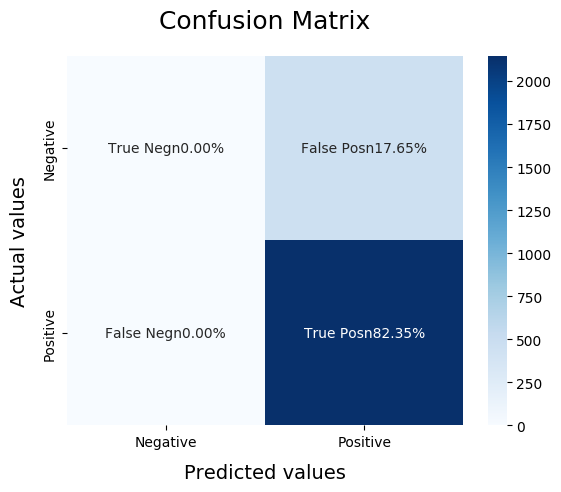

In [5]:
# TRAININIG BERNOULLI AND TESTING IT
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
import time
import seaborn as sns
text_word_list=[]
y=[]
index = 0
for i in lines_with_value:
    # print(i[0][0])
    labell = i[1][0].strip()
    if(labell == "TRS" or labell == "BJP" or labell == "YCP" or labell == "TDP" or labell == "Congress"):
        index = 1
    else:
        index = 0
    for j in i[0]:
        # print(type(j))
        word_vector = embedding_dict[j]
        list_for_each_word = []
        for dimension_value in word_vector:
            list_for_each_word.append(dimension_value)
        text_word_list.append(list_for_each_word)
        y.append(index)

# print(len(text_word_list),len(y))
# text_word_list = sparse.csr_matrix(text_word_list)
# y = sparse.csr_matrix(y)
# print(y.getnnz())
# print(y)
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    # print(cf_matrix.flatten())
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]  
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

        
X_train, X_test, y_train, y_test = train_test_split(text_word_list, y, test_size=0.2, random_state=1000)
# print(X_test,y_test)
BNBmodel = BernoulliNB()
start = time.time()
BNBmodel.fit(X_train, y_train)
end = time.time()
# print("The execution time of this model is {:.2f} seconds\n".format(end-start))
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)
count_temp = 0
for i in y_train:
    if(i == 0):
        count_temp+=1
# print(count_temp,len(y_train))